# Data Analysis

In [221]:
%matplotlib inline
from collections import OrderedDict
from math import sqrt, pi, sin, cos
from random import random, randint, choice
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

-----

# A) Linear Regression

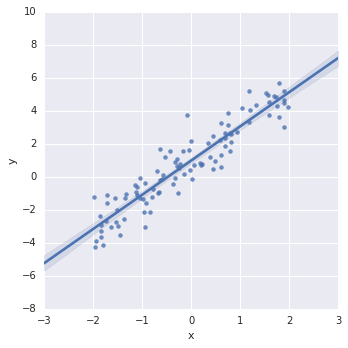

In [138]:
def generate_linear_data(a, b, stdev=1, n_points=100, min_x=-2, max_x=2,
                         outlier=False, outlier_distance=100):
    data = []
    for i in range(n_points):
        x = np.random.uniform(min_x, max_x)
        noise = np.random.normal(0, stdev) if stdev > 0 else 0
        y = a * x + b + noise
        data.append((x, y))
    if outlier:
        data[-1] = (data[-1][0], data[-1][1] + outlier_distance)
    return to_df(data)

def read_data(filename, as_df=True):
    with open('data/{0}'.format(filename)) as f:
        lines = f.read().split('\n')
        data = [tuple(map(float, line.split()))
                for line in lines if line]
    if as_df:
        return pd.DataFrame(data, columns=['x', 'y'])
    return data

def to_df(data_list):
    return pd.DataFrame(data_list, columns=['x', 'y'])

df1 = read_data('linreg.txt')
df2 = read_data('faithful.txt')
df3 = generate_linear_data(a=2, b=1)
sns.lmplot(x='x', y='y', data=df3)

### Utils for evaluation & visualization

In [88]:
def evaluate(a, b, df):
    sqerrors = ([sqerror(a, b, point) for point in df.itertuples()])
    rmse = sqrt(np.mean(sqerrors))
    return rmse

def sqerror(a, b, point):
    py = a * point.x + b
    return (point.y - py) ** 2

def print_results(a, b, error):
    print('y = {a:.2f}x + {b:.2f} ---> rmse={e:.2f}'
          .format(a=a, b=b, e=error))

def show_solution(a, b, df):
    print_results(a, b, evaluate(a, b, df))
    ax = df.plot.scatter(x='x', y='y')
    x1 = df.x.min()
    x2 = df.x.max()
    y1 = x1 * a + b
    y2 = x2 * a + b
    ax.plot([x1, x2], [y1, y2], c='c')
    plt.xlim(left=x1, right=x2)
    
def solve(df, fn, **kwargs):
    a, b = fn(df, **kwargs)
    show_solution(a, b, df)
    
def solve_evaluate(df, fn, **kwargs):
    result = fn(df, **kwargs)
    return evaluate(*result, df)

### Analytic solution

y = 2.40x + 1.45 ---> rmse=1.01


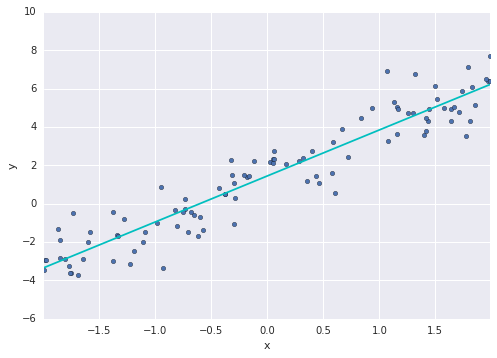

In [64]:
def analytic_solution(df):
    n, x, y = len(df), df.x, df.y
    a = ((n * sum(x*y) - sum(x)*sum(y))
         / (n * sum(x**2) - sum(x)**2))
    b = np.mean(y) - a * np.mean(x)
    return a, b

solve(df1, analytic_solution)

y = 10.73x + 33.47 ---> rmse=5.89


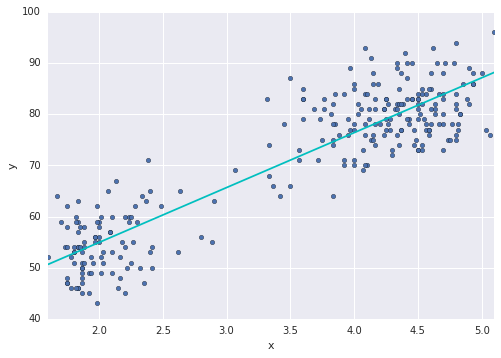

In [65]:
solve(df2, analytic_solution)

### Grid search

y = 2.38x + 1.45 ---> rmse=1.01


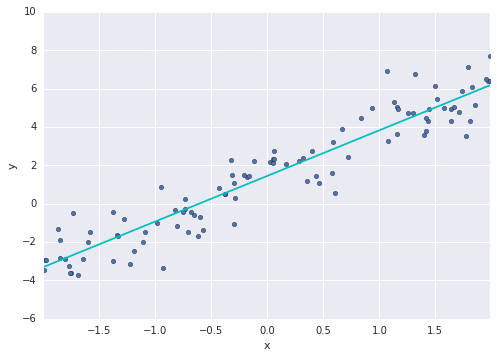

In [66]:
def grid_search(df, steps=10, a_min=-1, a_max=1, b_min=-1, b_max=1):
    best_error, best_a, best_b = inf, None, None
    for a in np.linspace(a_min, a_max, num=steps):
        for b in np.linspace(b_min, b_max, num=steps):
            error = evaluate(a, b, df)
            if error < best_error:
                best_error, best_a, best_b = error, a, b
    return best_a, best_b


solve(df1, grid_search, a_min=1, a_max=5, b_min=0, b_max=2, steps=30)

### Influence of noise & amount of data

Without any noise, we can learn the original parameters exactly:

y = 2.00x + 1.00 ---> rmse=0.00


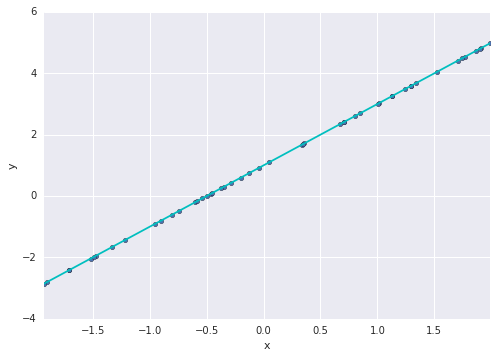

In [73]:
df = generate_linear_data(a=2, b=1, stdev=0, n_points=50)
solve(df, analytic_solution)

When we add some noise, we cannot get a perfect fit anymore:

y = 2.12x + 1.44 ---> rmse=1.93


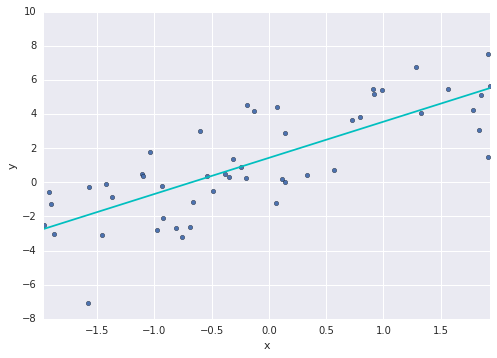

In [116]:
df = generate_linear_data(a=2, b=1, stdev=2, n_points=50)
solve(df, analytic_solution)

Let us abstract over the amount of noise:

(0, 11)

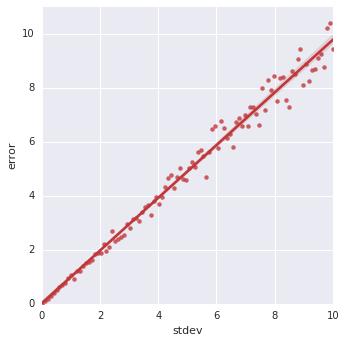

In [134]:
max_stdev = 10
stdevs = np.linspace(0, max_stdev, num=100)
errors = [
    solve_evaluate(
        generate_linear_data(a=2, b=1, stdev=stdev, n_points=100),
        analytic_solution)
    for stdev in stdevs]
results = pd.DataFrame({'stdev': stdevs, 'error': errors})
with sns.color_palette('RdBu'):
    sns.lmplot(data=results, x='stdev', y='error')
plt.xlim(left=0, right=max_stdev)
plt.ylim(bottom=0, top=11)

We can see that for a fixed number of points and increasing noise, the mean squared error increases proportionally to the standard deviation of noise. Furthermore, not only the bias, but also the variance of estimates is increasing.

Now let us look what happens with more data points:

y = 2.08x + 0.94 ---> rmse=2.01


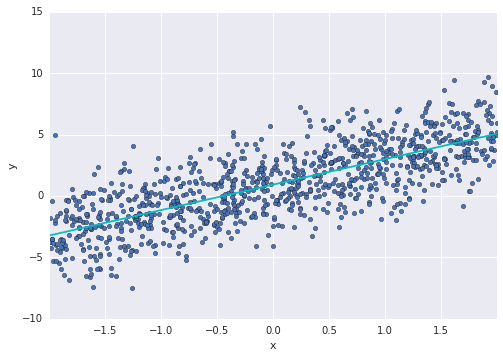

In [81]:
df = generate_linear_data(a=2, b=1, stdev=2, n_points=1000)
solve(df, analytic_solution)

In this case, the RMSE is similar for both 50 and 1000 points. Let us abstract the number of points to get a more complete picture:

(1.5, 2.5)

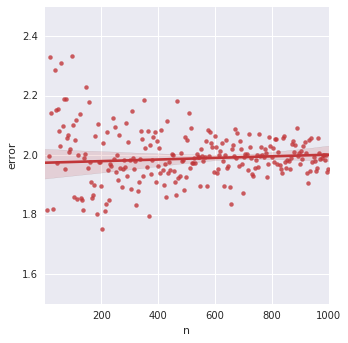

In [135]:
max_points= 1000
points = list(range(3, max_points+1, 4))
errors = [
    solve_evaluate(
        generate_linear_data(a=2, b=1, stdev=2, n_points=n_points),
        analytic_solution)
    for n_points in points]
results = pd.DataFrame({'n': points, 'error': errors})
with sns.color_palette('RdBu'):
    sns.lmplot(data=results, x='n', y='error')
plt.xlim(left=2, right=1000)
plt.ylim(bottom=1.5, top=2.5)

It seems that the bias on the training set is slightly increasing with the amout of training data. On the other hand, the variance is decreasing with more points.

### Influence of outliers

A single outlier can significantly influence the fitted line and RMSE, especially if it's horizontally on one of the edges of the spectrum:

y = 5.19x + 5.09 ---> rmse=27.97


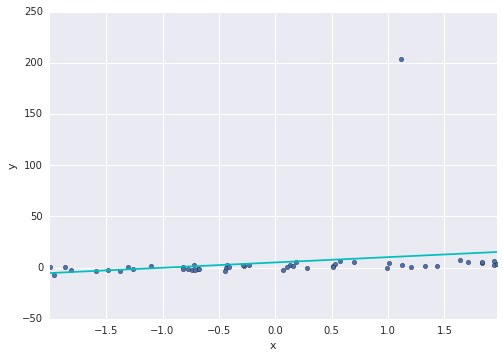

In [137]:
df = generate_linear_data(a=2, b=1, stdev=2, n_points=50, outlier=True)
solve(df, analytic_solution)

As we increase the distance of the outlier, the RMSE is increasing superlinearly:

(0, 14.0)

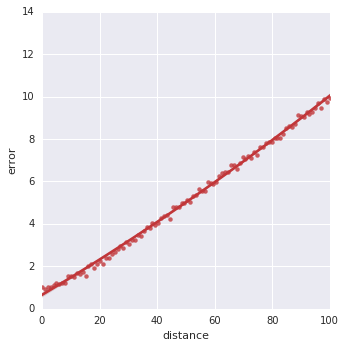

In [147]:
max_distance = 100
distances = np.linspace(0, max_distance, num=100)
errors = [
    solve_evaluate(
        generate_linear_data(a=2, b=1, stdev=1, n_points=100,
                             outlier=True, outlier_distance=dist),
        analytic_solution)
    for dist in distances]
results = pd.DataFrame({'distance': distances, 'error': errors})
with sns.color_palette('RdBu'):
    sns.lmplot(data=results, x='distance', y='error', order=2)
plt.xlim(left=0, right=max_distance)
plt.ylim(bottom=0)

Even with a single outlier, the solution is less stable - the variance is a lot higher:

In [143]:
errors = [
    solve_evaluate(generate_linear_data(
        a=2, b=1, stdev=1, n_points=100, outlier=False),
        analytic_solution)
    for _ in range(100)]
print('Std without an outlier:', np.std(errors))

errors = [
    solve_evaluate(generate_linear_data(
        a=2, b=1, stdev=1, n_points=100, outlier=True),
        analytic_solution)
    for _ in range(100)]
print('Std with an outlier:', np.std(errors))

Std without an outlier: 0.072606133525
Std with an outlier: 0.103395751926


-----

# B) Clusters Detection

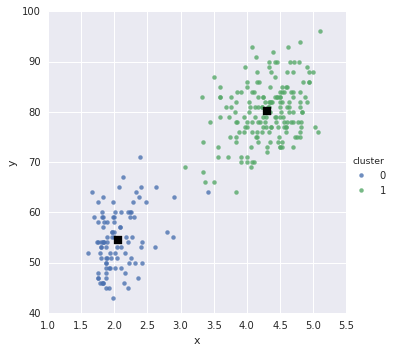

In [259]:
def kmeans(df, k, max_iter=15, return_iter=False):
    ndf, mu, std = normalize(df)
    centers = create_random_centers(k)
    for i_iter in range(1, max_iter+1):
        ndf['cluster'] = compute_clusters(ndf, centers)
        prev_centers, centers = centers, compute_centers(ndf)
        if centers.equals(prev_centers):
            break
    # Denormalization.
    df = df.assign(cluster=ndf.cluster)
    centers = (centers * std) + mu
    if return_iter:
        return i_iter
    return df, centers

def normalize(df):
    mu = df.mean()
    std = df.std()
    ndf = (df - mu) / std
    return ndf, mu, std

def create_random_centers(k):
    return to_df(np.random.random((k, 2)))

def compute_clusters(df, centers):
    return [find_closest(point, centers) for i, point in df.iterrows()]
    
def find_closest(point, centers):
    return min(range(len(centers)),
               key=lambda i: distance(point, centers.iloc[i]))

def distance(a, b):
    return sqrt(((a - b) ** 2).sum())

def compute_centers(df):
    return df.groupby('cluster').mean()

def show_kmeans(df, k):
    df, centers = kmeans(df, k)
    show_clusters(df, centers)
    
def show_clusters(df, centers=None):
    g = sns.lmplot(data=df, x='x', y='y', hue='cluster', fit_reg=False)
    if centers is not None:
        g.ax.scatter(centers.x, centers.y, c='k', marker='s', s=50)

show_kmeans(df2, k=2)

Simple generator of clusters:

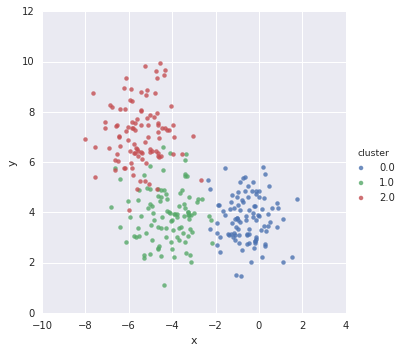

In [246]:
def generate_cluster_data(k, points_per_cluster=100, overlap=0.1):
    data = []
    center = np.array([0., 0.])
    center_dist = 4 * (1 - overlap)
    for i_cluster in range(k):
        angle= np.random.uniform(0, 2*pi)
        center += center_dist * np.array([cos(angle), sin(angle)])
        for i_point in range(points_per_cluster):
            point = center + np.random.normal(size=2)
            data.append(np.append(point, i_cluster))
    return pd.DataFrame(data, columns=['x', 'y', 'cluster'])
            
show_clusters(generate_cluster_data(3, overlap=0.1))

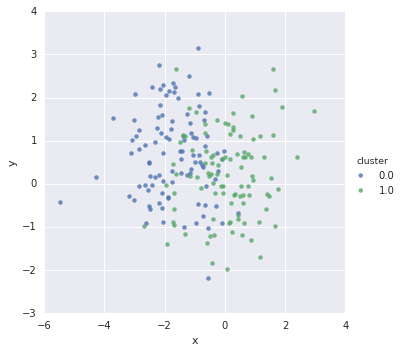

In [253]:
show_clusters(generate_cluster_data(2, overlap=0.5))

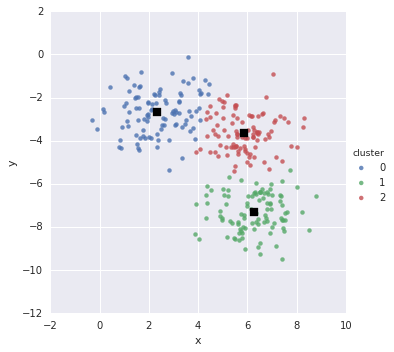

In [247]:
show_kmeans(generate_cluster_data(3, overlap=0.1), k=3)

### Overlapping

Let us explore the relationship between the amount of overlapping and number of iterations.

(0, 10)

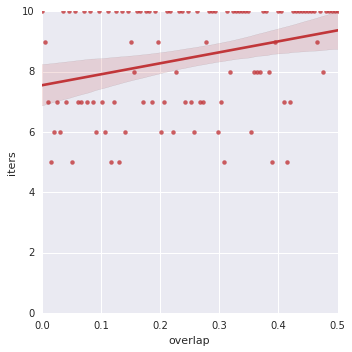

In [260]:
max_overlap = 0.5
overlaps = np.linspace(0, max_overlap, num=100)
iters = [
    kmeans(
        generate_cluster_data(3, overlap=overlap),
        k=3,
        max_iter=10,
        return_iter=True)
    for overlap in overlaps]
results = pd.DataFrame({'overlap': overlaps, 'iters': iters})
with sns.color_palette('RdBu'):
    sns.lmplot(data=results, x='overlap', y='iters', fit_reg=True)
plt.xlim(left=0, right=max_overlap)
plt.ylim(bottom=0, top=10)

(It should not have been capped at 10 iterations, but it took quite long, so I prefer not to repeat the computation.) It seems to me that there is a positive relationship between the amount of overlappint and the number of iterations, but the relationship is week.